In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# torch.manual_seed(42)

In [3]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'device: {device}')

device: cpu


In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,y,z):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,y,z], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)


            
        b = self.linears[-1](a) 
         
        return b
    
    # def forward_direct(self, x):
        
    #     z = x.float()
    #     H = self.linears[0].weight

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)
    #         z = self.activation(L)
    #         G = (1-torch.square(z))*H.t() #\sigma'(L)*H
    #         H = torch.matmul(self.linears[i+1].weight,G.t())

    #     z = self.linears[-1](z)
         
    #     return z,H

In [5]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([3,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [6]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [6]:
# Create the training data

x = torch.linspace(0,1,30, requires_grad = True).view(-1,1)
y = torch.linspace(0,1,30, requires_grad = True).view(-1,1)
z = torch.linspace(0,1,30, requires_grad = True).view(-1,1)



if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(y) != True:         
    y = torch.from_numpy(y) 
if torch.is_tensor(z) != True:         
    z = torch.from_numpy(z) 


#convert to float
x = x.float()
y = y.float()
z = z.float()

    
x_train,y_train,z_train = torch.meshgrid(x.squeeze(),y.squeeze(),z.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device).requires_grad_(True)     
# y_train = y_train.reshape(-1,1).to(device).requires_grad_(True) 
# z_train = z_train.reshape(-1,1).to(device).requires_grad_(True)
     

x_train = x_train.reshape(-1,1).requires_grad_(True)     
y_train = y_train.reshape(-1,1).requires_grad_(True) 
z_train = z_train.reshape(-1,1).requires_grad_(True) 
     



In [7]:
# Create boundary points

def generate_boundary_points(N = 10000):
    x_0 = torch.zeros(N,1) ; x_1 = torch.ones(N,1); y_0_1 = torch.linspace(0,1.,N).unsqueeze(-1); z_0_1 = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_l = torch.cat([x_0,ylr], dim = 1); b_r = torch.cat([x_1,ylr], dim = 1)

    y_0 = torch.zeros(N,1); y_1 = torch.ones(N,1); x_0_1 = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_b = torch.cat([xbt,y_0], dim = 1); b_t = torch.cat([xbt,y_1], dim = 1)
    z_0 = torch.zeros(N,1); z_1 = torch.ones(N,1)

    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    
    y_0 = y_0.to(device)
    y_1 = y_1.to(device)

    z_0 = z_0.to(device)
    z_1 = z_1.to(device)

    x_0_1 = x_0_1.to(device)
    y_0_1 = y_0_1.to(device)
    z_0_1 = z_0_1.to(device)


    return x_0, x_1,  y_0, y_1, z_0, z_1, x_0_1, y_0_1, z_0_1









In [8]:
def pde_residual(x, y, z):
    u = PINN(x,y,z)

    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    du_dz = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0]
    

    du_dx_x = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    du_dy_y = torch.autograd.grad(du_dy, y, torch.ones_like(du_dy), create_graph=True)[0]
    du_dz_z = torch.autograd.grad(du_dz, z, torch.ones_like(du_dz), create_graph=True)[0]
    

    res_pde = du_dx_x + du_dy_y + du_dz_z

    return res_pde


In [10]:
def boundary_condition(x,y,z):

    x_0, x_1,  y_0, y_1, z_0, z_1, x_0_1, y_0_1, z_0_1 = generate_boundary_points()

    u_x_0 = PINN(x_0, y_0_1, z_0_1)
    u_x_1 = PINN(x_1,y_0_1, z_0_1)

    u_y_0 = PINN(x_0_1,y_0,z_0_1)
    u_y_1 = PINN(x_0_1,y_1,z_0_1)

    u_z_0 = PINN(x_0_1,y_0_1,z_0)
    u_z_1 = PINN(x_0_1,y_0_1,z_1)

   

    res_x_0 = u_x_0 - torch.zeros_like(x_0)
    res_x_1 = u_x_1 - ((torch.sin(np.pi * y_0_1)) * (torch.sin(np.pi * z_0_1)))
    res_y_0 = u_y_0 - torch.zeros_like(y_0)
    res_y_1 = u_y_1 - torch.zeros_like(y_1)
    res_z_0 = u_z_0 - torch.zeros_like(z_0)
    res_z_1 = u_z_1 - torch.zeros_like(z_1)
    

    return res_x_0,res_x_1,res_y_0,res_y_1, res_z_0,res_z_1

In [12]:
def compute_losses():
   res_pde = pde_residual(x_train, y_train, z_train) 
   
   res_x_0,res_x_1,res_y_0,res_y_1, res_z_0,res_z_1 = boundary_condition(x_train, y_train, z_train)

   loss_pde = torch.mean(res_pde**2)
   
   loss_bc = torch.mean(res_x_0**2) + torch.mean(res_x_1**2) + torch.mean(res_y_0**2) + torch.mean(res_y_1**2) + torch.mean(res_z_0**2) + torch.mean(res_z_1**2)

   total_loss = loss_pde + loss_bc

   return total_loss

In [26]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [13]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [ ]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





In [14]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()
ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        print(f'Outer {ep}, Loss: {total_loss.item()}')

    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 2.2101128101348877
Reached threshold loss 0.002 at outer step 91
Training stopped at outer step 91, total time 221.29 s


In [ ]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  5249.59 MB


In [15]:
import math

def u_closed_form_3D(x, y, z):
    pi = torch.tensor(math.pi)
    r2 = torch.sqrt(torch.tensor(2.0))
    d = torch.sinh(pi * r2)
    sol = (torch.sinh(pi * r2 * x) / d) * torch.sin(pi * y) * torch.sin(pi * z)
    return sol

In [16]:
x_test = torch.linspace(0,1,20).view(-1,1)
y_test = torch.linspace(0,1,20).view(-1,1)
z_test = torch.linspace(0,1,20).view(-1,1)




# if torch.is_tensor(x_test) != True:         
#     x_test = torch.from_numpy(x_test)  
# if torch.is_tensor(y_test) != True:         
#     y_test = torch.from_numpy(y_test) 


# #convert to float
# x = x_test.float()
# y = y_test.float()


    
# x_test,y_test = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')
x_test,y_test,z_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(),z_test.squeeze(), indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


x_test = x_test.reshape(-1,1)     
y_test = y_test.reshape(-1,1) 
z_test = z_test.reshape(-1,1)


u_true = u_closed_form_3D(x_test, y_test, z_test) 


u_pred = PINN(x_test,y_test,z_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 1.367e-03


In [17]:
def compare(PINN):
    PINN.eval()


    x = torch.linspace(0,1,20).view(-1,1)
    y = torch.linspace(0,1,20).view(-1,1)
    z = torch.linspace(0,1,20).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
    x_test,y_test,z_test = torch.meshgrid(x.squeeze(),y.squeeze(),z.squeeze(), indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


    x_test = x_test.reshape(-1,1)     
    y_test = y_test.reshape(-1,1) 
    z_test = z_test.reshape(-1,1)


    u_true = u_closed_form_3D(x_test, y_test,z_test).reshape(20,20,20) 


    u_pred = PINN(x_test,y_test,z_test)

    u_pred_np = u_pred.reshape(20,20,20).detach().cpu()



    # Plot three orthogonal mid-slices with shared color scale
    vmin = 0.0
    vmax = float(torch.max(u_true))  # ~1.0
    ix = 20 // 2; iy = 20 // 2; iz = 20 // 2

    fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=True)

    # Slice x = const (YZ-plane)
    im = axs[0,0].imshow(u_true[ix,:,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[0,0].set_title(f"True: x={x[ix]:.2f}"); axs[0,0].set_xlabel('y'); axs[0,0].set_ylabel('z')
    fig.colorbar(im, ax=axs[0,0])

    im = axs[0,1].imshow(u_pred[ix,:,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[0,1].set_title(f"PINN: x={x[ix]:.2f}"); axs[0,1].set_xlabel('y'); axs[0,1].set_ylabel('z')
    fig.colorbar(im, ax=axs[0,1])


    # Slice y = const (XZ-plane)
    im = axs[1,0].imshow(u_true[:,iy,:].cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[1,0].set_title(f"True: y={y[iy]:.2f}"); axs[1,0].set_xlabel('x'); axs[1,0].set_ylabel('z')
    fig.colorbar(im, ax=axs[1,0])

    im = axs[1,1].imshow(u_pred[:,iy,:].cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[1,1].set_title(f"PINN: y={y[iy]:.2f}"); axs[1,1].set_xlabel('x'); axs[1,1].set_ylabel('z')
    fig.colorbar(im, ax=axs[1,1])


    # Slice z = const (XY-plane)
    im = axs[2,0].imshow(u_true[:,:,iz].cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[2,0].set_title(f"True: z={z[iz]:.2f}"); axs[2,0].set_xlabel('x'); axs[2,0].set_ylabel('y')
    fig.colorbar(im, ax=axs[2,0])

    im = axs[2,1].imshow(u_pred[:,:,iz].cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[2,1].set_title(f"PINN: z={z[iz]:.2f}"); axs[2,1].set_xlabel('x'); axs[2,1].set_ylabel('y')
    fig.colorbar(im, ax=axs[2,1])

    plt.show()

TypeError: unsupported format string passed to Tensor.__format__

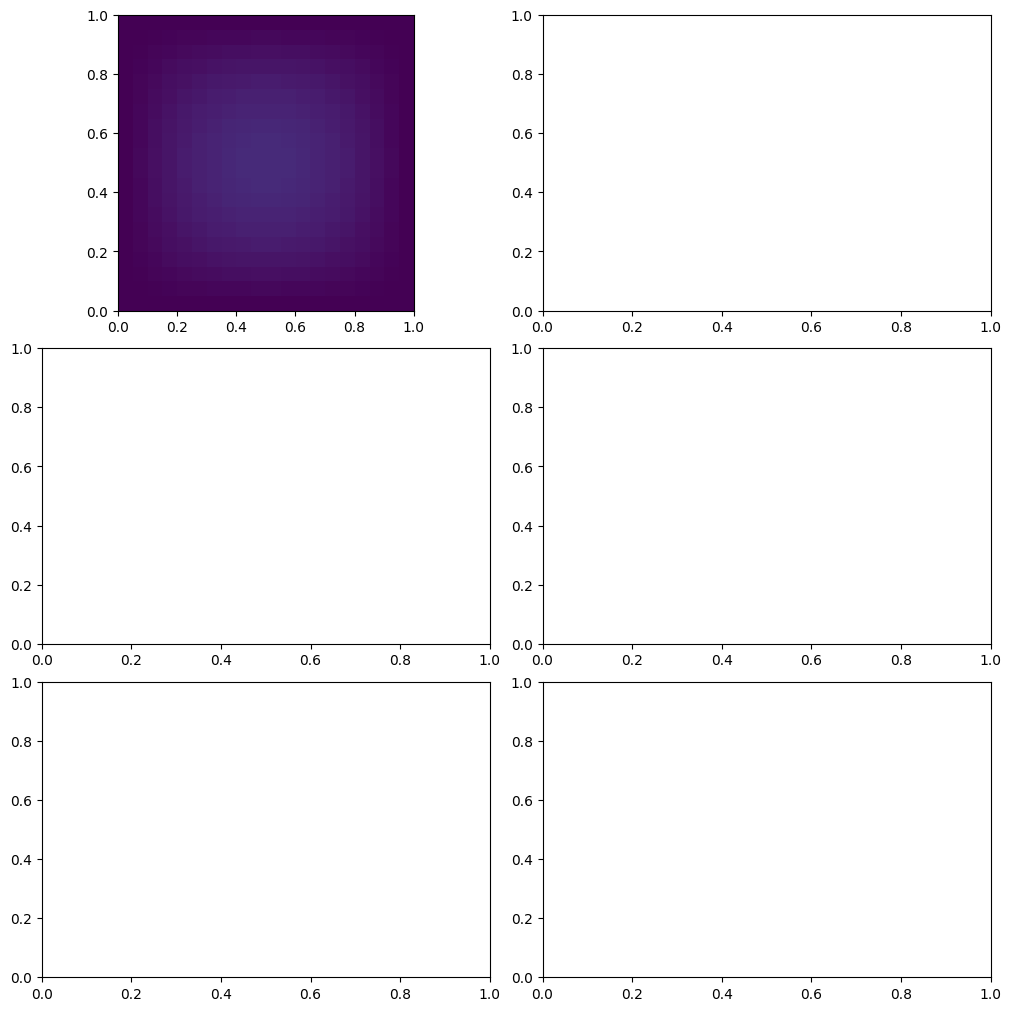

In [18]:
compare(PINN)